In [10]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

# File Tools for local
import pandas as pd

# Sampling
from pyDOE import lhs

# Optimization
import torch
from botorch.models import HeteroskedasticSingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
## Mixed
from gpytorch.constraints import Interval
from botorch.models import MixedSingleTaskGP
from botorch.optim import optimize_acqf_mixed
from botorch.utils.transforms import normalize, unnormalize

# Set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32


cpu


In [11]:
def gp_evaluate(gp, test_x):
    # Get posterior predictions
    gp.eval()
    with torch.no_grad():
        posterior = gp.posterior(test_x)

    mean = posterior.mean.squeeze().numpy()
    lower, upper = posterior.mvn.confidence_region()
    var = posterior.variance.squeeze().numpy()

    return mean, var

# Define all combinations of variables for triple pair plots
variable_combinations = [('time', 'temp'), ('time', 'sulf'), ('time','anly'), ('temp', 'sulf'), ('temp','anly'), ('sulf', 'anly')]
feature_names = ['time', 'temp', 'sulf', 'anly']

# Function to generate input data based on variable combination
def generate_input_data(A, B, c, d, combination):
    if combination == ('time', 'temp'):
        return torch.tensor(np.array([[A[i, j], B[i, j], c, d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('time', 'sulf'):
        return torch.tensor(np.array([[A[i, j], c, B[i, j], d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)        
    elif combination == ('time', 'anly'):
        return torch.tensor(np.array([[A[i, j], d, B[i, j], c ] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('temp', 'sulf'):
        return torch.tensor(np.array([[d, A[i, j], B[i, j], c] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('temp', 'anly'):
        return torch.tensor(np.array([[d, A[i, j], c, B[i, j]] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('sulf', 'anly'):
        return torch.tensor(np.array([[d, c,A[i, j], B[i, j]] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)

def staircase_plot_with_histograms(select, means, var, train_x, train_y, train_yvar, test_x, color, name):
    if select == 'mean':
        versions = means
        cmap_name = color
        y = train_y.numpy()
    elif select == 'var':
        versions = [var] * len(means)  # Use the same variance for all means
        cmap_name = 'seismic'
        y = train_yvar.numpy()

    num_features = train_x.shape[1]  # Assuming 4D input
    feature_names = ["time", "temp", "sulf", "anly"]
    
    fig, axes = plt.subplots(num_features, num_features, figsize=(12, 10))
    count = 0
    for i in range(num_features):
        for j in range(num_features):
            ax = axes[i, j]
            if i < j:  # Upper triangle (leave empty)
                # ax.scatter(train_x[:, j].numpy(), train_x[:, i].numpy(), c=y, cmap=cmap_name, s=500, alpha=0.7,marker='.')
                # ax.set_xlabel(feature_names[j])
                # ax.set_ylabel(feature_names[i])
                # ax.set_box_aspect(1)
                ax.axis('off')
            elif i == j:  # Diagonal (histograms)
                ax.hist(train_x[:, i].numpy(), bins=10, color='gray', edgecolor='black', alpha=0.7)
                ax.set_xlabel(feature_names[i])
                ax.set_box_aspect(1)  # Set the aspect ratio to be equal (cube-shaped)
                ax.set_ylabel("Frequency")
            else:  # Lower triangle (pairwise scatter plots)
                for version in versions:
                    ax.scatter(train_x[:, j].numpy(), train_x[:, i].numpy(), c=y, cmap=cmap_name, s=50, alpha=0.5,marker='o')
                    sc = ax.contourf(A, B, means[count].reshape(num_points, num_points), cmap=cmap_name, alpha=0.7, levels=10,vmax=1, vmin=0)
                fig.colorbar(sc, ax=ax, orientation='vertical')
                ax.set_xlabel(feature_names[j])
                ax.set_ylabel(feature_names[i])
                ax.set_box_aspect(1)
                count += 1
            plt.tight_layout()


>### Import data from Round 1

In [12]:
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

# import data from csv
data_R1 = pd.read_csv('/Users/ctuwsunlab/Documents/GitHub/PNNL-ML_for_Organic_Flow_Battery_Materials/Round1/extracted_data_round1.csv')
data_R1 
# average and standard deviation of the repeats
avg_data01 = data_R1.groupby('01_time').mean().reset_index()[['01_time','01_temp','01_sulf','01_anly','01_yield product']].rename(columns = {'01_time':"time",'01_temp':"temp",'01_sulf':"sulf",'01_anly':"anly",'01_yield product':"yield product"})
std_data01 = data_R1.groupby('01_time').std().reset_index()[['01_time','01_temp','01_sulf','01_anly','01_yield product']].rename(columns = {'01_time':"time",'01_temp':"temp",'01_sulf':"sulf",'01_anly':"anly",'01_yield product':"yield product"})


>### Build Gaussian Process Regression

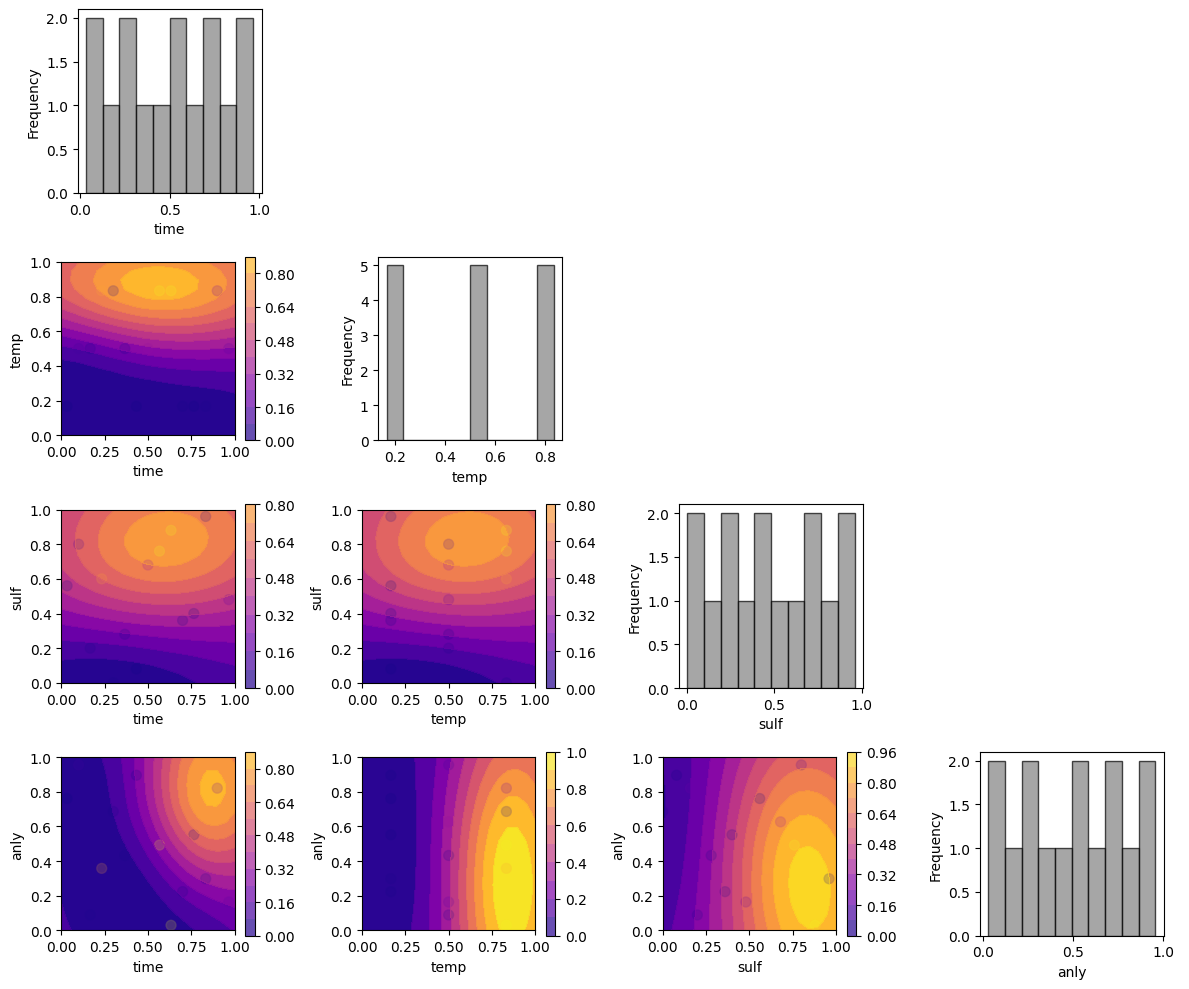

In [13]:
# Define the bounds for continuous variables
bounds = torch.tensor([
    [30.0, 20.0, 75.0, 33.0],  # Lower bounds for the 3 continuous variables
    [600.0, 170.0,100.0, 100.0]   # Upper bounds for the 3 continuous variables
])

x = torch.tensor([avg_data01['time'],avg_data01['temp'],avg_data01['sulf'],avg_data01['anly']],dtype=torch.float32).T#
norm_x = normalize(x, bounds)
y = torch.tensor(avg_data01['yield product'],dtype=torch.float32).reshape(-1,1)
yvar = torch.tensor(std_data01['yield product'],dtype=torch.float32).reshape(-1,1)

train_x = torch.tensor(norm_x, dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y, dtype=dtype)
train_yvar = torch.tensor(yvar, dtype=dtype)

gp_model = HeteroskedasticSingleTaskGP(train_x, train_y,train_yvar).to(device=device, dtype=dtype)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

# Visualized the Model
# Generate a grid
num_points = 20  # Points per axis for plotting
a = np.linspace(0, 1, num_points)
b = np.linspace(0, 1, num_points)
c_slices = np.linspace(0, 1, 12)  # Slicing variable
c_fixed = 0.75  # Example fixed value for c - three temperatures
d_fixed =  0.75 # Example fixed value for d - three temperatures

# # Create meshgrid for a, b
A, B = np.meshgrid(a, b)

mean_values = []
var_values = []
for combination in variable_combinations:
    input_data = generate_input_data(A, B, c_fixed, d_fixed, combination)
    mean, var =  gp_evaluate(gp_model, input_data)
    mean_values.append(mean)
    var_values.append(var)

staircase_plot_with_histograms('mean', mean_values, var_values, train_x, train_y, train_yvar , input_data, 'plasma', f"Combination: {combination}")


In [14]:
# BO set up
batch_size = 15 #train_size
# For EI 
best_f = torch.tensor(1 ,dtype=dtype) 
# Define the qEI acquisition function
qEI = qExpectedImprovement(model=gp_model, best_f=best_f)

candidate, _ = optimize_acqf(
    acq_function=qEI,
    bounds=torch.tensor([[0., 0., 0. , 0.], [1., 1., 1.,1.]], dtype=dtype, device=device),
    q=batch_size,
    num_restarts=15,
    raw_samples=100,
    options={"dtype": dtype, "device": device}
)

candidates = unnormalize(candidate, bounds)
data = {
    'time': candidates[:,0]//1,
    'temp': candidates[:,1]//1,
    'sulf': candidates[:,2]//1,
    'anly': candidates[:,3]//1
}
data_df = pd.DataFrame(data)
data_df

,time,temp,sulf,anly
0,373.0,170.0,95.0,79.0
1,338.0,141.0,97.0,53.0
2,463.0,79.0,76.0,99.0
3,372.0,158.0,99.0,54.0
4,451.0,154.0,93.0,46.0
5,235.0,149.0,97.0,51.0
6,242.0,170.0,96.0,54.0
7,170.0,114.0,89.0,61.0
8,301.0,132.0,96.0,41.0
9,333.0,157.0,94.0,46.0


>### Cluster

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the 'temp' column for clustering
temp_data = data_df[['temp']]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
temp_data_scaled = scaler.fit_transform(temp_data)

# Choose the number of clusters
num_clusters = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init=int((20.0+170.0)/2), random_state=42)

data_df['temp_cluster'] = kmeans.fit_predict(temp_data_scaled)
kmeans.fit(temp_data)

# Get the centroids
centroids = kmeans.cluster_centers_
print(centroids.round())

[[152.]
 [ 30.]
 [ 98.]]


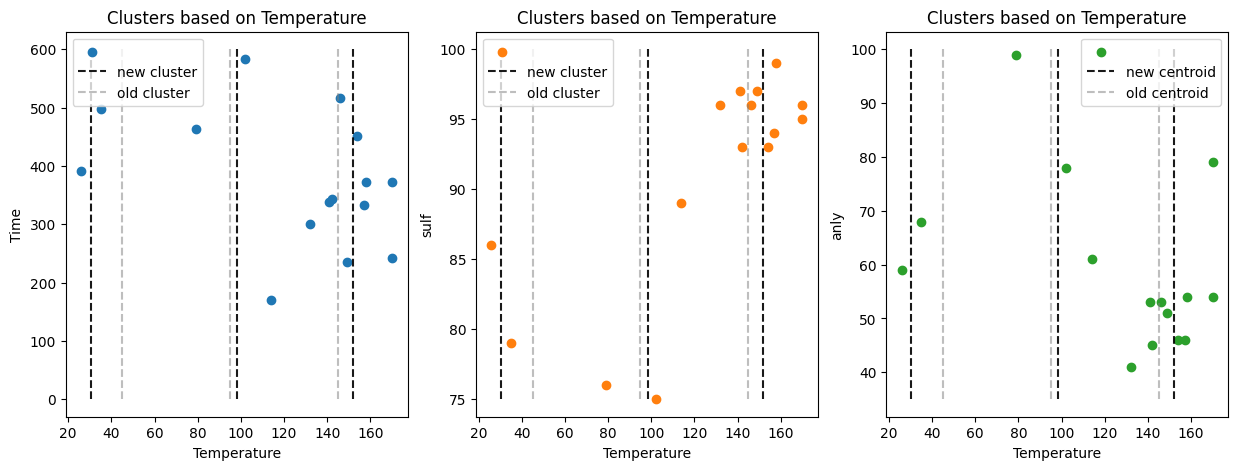

In [16]:
old = [45,95,145]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(data_df['temp'], data_df['time'], color="tab:blue")
plt.vlines(centroids,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.title('Clusters based on Temperature')
plt.legend(['','new cluster','old cluster'])

plt.subplot(1,3,2)
plt.scatter(data_df['temp'], data_df['sulf'],color="tab:orange")
plt.vlines(centroids,75,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,75,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('sulf')
plt.title('Clusters based on Temperature')
plt.legend(['','new cluster','old cluster'])


plt.subplot(1,3,3)
plt.scatter(data_df['temp'], data_df['anly'], color="tab:green")
plt.vlines(centroids,35,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,35,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('anly')
plt.title('Clusters based on Temperature')
plt.legend(['','new centroid','old centroid'])

>### Mixed Variable BO

In [17]:
# BO parameters
batch_size = 15

# Discrete variable choices from 1D BO
discrete_choices = normalize(torch.tensor(centroids),[20,170])
fixed_features_list = [{1: float(discrete_choices[0])},{1: float(discrete_choices[1])},{1: float(discrete_choices[2])}]

# Build Mixed variable GP
gp_mixed = MixedSingleTaskGP(train_x, train_y, cat_dims=[1],train_Yvar=train_yvar)
mll = ExactMarginalLogLikelihood(gp_mixed.likelihood, gp_mixed)
fit_gpytorch_model(mll)

# Set of aquisition functions that can be used for mixed
qEI = qExpectedImprovement(model=gp_mixed, best_f=best_f)

# Re-run the BO for the mixed with constrained temps
candidate_mixed, _ = optimize_acqf_mixed(
    acq_function=qEI,
    bounds=torch.tensor([[0., 0., 0. , 0.], [1., 1., 1.,1.]], dtype=dtype, device=device),
    q=batch_size,
    fixed_features_list=fixed_features_list,
    num_restarts=10,
    raw_samples=15,
    options={"dtype": dtype, "device": device}
)

candidates_mixed = unnormalize(candidate_mixed, bounds)


mixed_data = {
    'time': candidates_mixed[:,0]//1,
    'temp': candidates_mixed[:,1]//1,
    'sulf': candidates_mixed[:,2]//1,
    'anly': candidates_mixed[:,3]//1
}
df_candidate_mixed = pd.DataFrame(mixed_data)

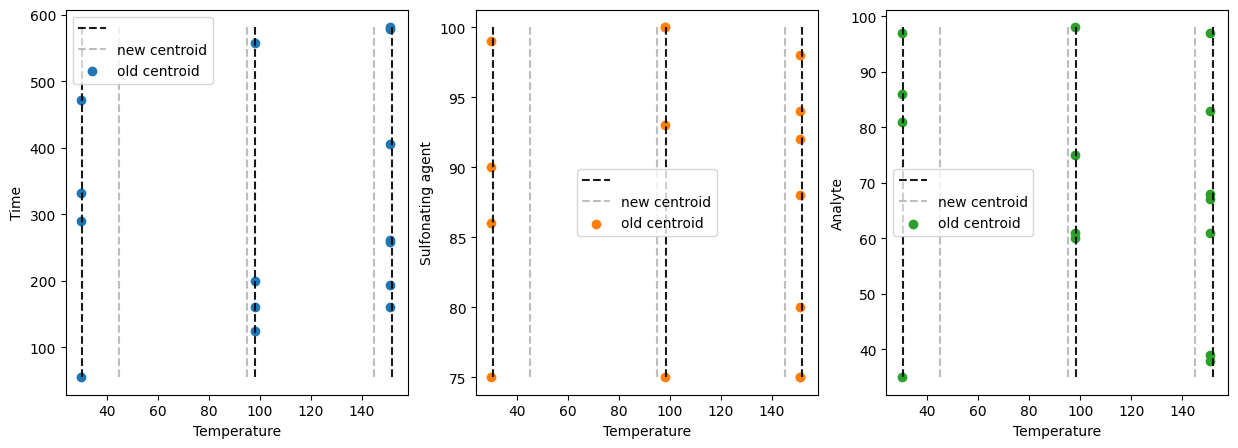

,time,temp,sulf,anly
0,160.0,151.0,75.0,83.0
1,332.0,30.0,75.0,97.0
2,125.0,98.0,93.0,60.0
3,578.0,151.0,98.0,68.0
4,290.0,30.0,90.0,86.0
5,55.0,30.0,99.0,81.0
6,200.0,98.0,75.0,61.0
7,558.0,98.0,100.0,98.0
8,581.0,151.0,88.0,38.0
9,471.0,30.0,86.0,35.0


In [18]:
# Visualize the new candidates
old = [45,95,145]

plt.figure(figsize=(15,5))
for i, (y, ylabel, color) in enumerate(zip(['time', 'sulf', 'anly'], ['Time', 'Sulfonating agent', 'Analyte'], ['tab:blue', 'tab:orange', 'tab:green'])):
    plt.subplot(1, 3, i+1)
    plt.vlines(centroids, df_candidate_mixed[y].min(), df_candidate_mixed[y].max(), color='k', linestyle='dashed', alpha=0.9)
    plt.vlines(old, df_candidate_mixed[y].min(), df_candidate_mixed[y].max(), color='tab:grey', linestyle='dashed', alpha=0.5)
    plt.scatter(df_candidate_mixed['temp'], df_candidate_mixed[y], color=color)
    plt.xlabel('Temperature')
    plt.ylabel(ylabel)
    plt.legend(['', 'new centroid', 'old centroid'])

plt.show()

df_candidate_mixed